**Imports**

In [5]:
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.dummy import DummyClassifier
from sklearn.metrics import f1_score, classification_report, confusion_matrix, precision_score, recall_score, roc_auc_score
from imblearn.pipeline import Pipeline as ImbPipeline
import pandas as pd
import sys

sys.path.append('C:\\Coding\\customer-churn-prediction\\src')
from utils import download_telco_churn_dataset, split_test_train
from preprocessing import get_preproc

RND_SEED = 42

**Getting Preprocessing and Data**

In [6]:
telco = pd.read_csv("../data/raw/WA_Fn-UseC_-Telco-Customer-Churn.csv")
X_train, X_test, y_train, y_test = split_test_train(telco)

preprocessing = get_preproc()

# Models

**Help Function**

Функция для оценки различных моделей на тестовой и тернировочных данных.

In [7]:
def fit_and_evaluate(models, cv=10, verbose=0):
    # Крафтим пайплайны для каждой модели
    pipelines = {}

    for name, model in models:
        pipelines[name] = (ImbPipeline([
            ("preproc", preprocessing.named_steps['preproc']),
            ("drop", preprocessing.named_steps['drop']),
            ("smote", preprocessing.named_steps['smote']),
            ("model", model)
        ]))

    metrics = {}

    # Оценивать модели будем по roc_auc score
    for name, model in pipelines.items():
        # Оценим сырые модельки на CV
        roc_auc_cv = cross_val_score(
            model, X_train, y_train, scoring='roc_auc', cv=cv, n_jobs=-1).mean()

        model.fit(X_train, y_train)
        
        print(len(model[:-1].get_feature_names_out()))

        y_pred_test = model.predict(X_test)

        # Metrics evaluating
        roc_auc_test = roc_auc_score(y_test, y_pred_test)
        
        if verbose == 1:
            print(f"MODEL ({name}):\nroc_auc_test: {roc_auc_test}\nroc_auc_cv: {roc_auc_cv}\n")

        metrics[name] = {
            'roc_auc_test': roc_auc_test,
            'roc_auc_cv': roc_auc_cv,
        }

    sorted_metrics = dict(
        sorted(metrics.items(), key=lambda item: -item[1]['roc_auc_cv']))

    print(f"ТОП МОДЕЛЕЙ по ROC-AUC:")
    for name, metric in sorted_metrics.items():
        print(
            "\n" + f"{name} : \nAUC: {metric['roc_auc_cv']}")

## Models Comparation

In [20]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

lgbm = LGBMClassifier(objective='binary', random_state=RND_SEED, verbose=-1)

cb = CatBoostClassifier(verbose=0)

lr = LogisticRegression(random_state=RND_SEED, penalty='l2')

lin_svc = LinearSVC(C=1, random_state=RND_SEED)

gb = GradientBoostingClassifier(random_state=RND_SEED)

svc = SVC(C=1, random_state=RND_SEED)

rnd_forest = RandomForestClassifier(random_state=RND_SEED, n_jobs=-1)

xgb = XGBClassifier(random_state=RND_SEED, n_jobs=-1)

models = [
    ("Logistic Regression L2", lr),
    ("LightGBM", lgbm),
    ("RND Forest", rnd_forest),
    ("XGB Classifier", xgb),
    ("Gradient Boosting", gb),
    ("Linear SVC", lin_svc),
    ("SVC", svc),
    ("CatBoost", cb)
]

In [21]:
fit_and_evaluate(models, verbose=1)

20
MODEL (Logistic Regression L2):
roc_auc_test: 0.7552545919553593
roc_auc_cv: 0.8429392111267152

20
MODEL (LightGBM):
roc_auc_test: 0.745919553592188
roc_auc_cv: 0.8297004101743954

20
MODEL (RND Forest):
roc_auc_test: 0.7455940478958382
roc_auc_cv: 0.8141126187203872

20
MODEL (XGB Classifier):
roc_auc_test: 0.7372691105427678
roc_auc_cv: 0.8171292222578369

20
MODEL (Gradient Boosting):
roc_auc_test: 0.7620630861040067
roc_auc_cv: 0.8414048326240341

20
MODEL (Linear SVC):
roc_auc_test: 0.7541760314138831
roc_auc_cv: 0.8421266618930832

20
MODEL (SVC):
roc_auc_test: 0.7502441292722623
roc_auc_cv: 0.817450137758002

20
MODEL (CatBoost):
roc_auc_test: 0.748222635562789
roc_auc_cv: 0.8343616863708483

ТОП МОДЕЛЕЙ по ROC-AUC:

Logistic Regression L2 : 
AUC: 0.8429392111267152

Linear SVC : 
AUC: 0.8421266618930832

Gradient Boosting : 
AUC: 0.8414048326240341

CatBoost : 
AUC: 0.8343616863708483

LightGBM : 
AUC: 0.8297004101743954

SVC : 
AUC: 0.817450137758002

XGB Classifier : 
AUC

Непосредственно в этой задаче мне важен `Recall` на положительном класса, то есть процент верно определенных `Churn`.

## LightGBM + GB + CatBoost

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import loguniform, uniform, randint


def fine_tuning_models(models_data):
    for name, model_data in models_data.items():
        models_data[name] = {
            "pipeline": ImbPipeline([
                ("preproc", preprocessing.named_steps['preproc']),
                ("drop", preprocessing.named_steps['drop']),
                ("smote", preprocessing.named_steps['smote']),
                ("model", model_data["model"]),
            ]),
            "param_distrib": model_data["param_disturb"],   
        }

        roc_auc_losses = cross_val_score(
            models_data[name]["pipeline"], X_train, y_train, cv=10, n_jobs=-1, scoring='roc_auc')
        print(f'{name} ROC-AUC:\n{pd.Series(roc_auc_losses).mean()}')

    print('=' * 50 + "Tuned models!!!" + '=' * 50)

    best_models = {}
    n_iter = 50

    for name, model_data in models_data.items():
        rnd_search = RandomizedSearchCV(model_data["pipeline"], param_distributions=model_data["param_distrib"],
                                        n_iter=n_iter, cv=5, n_jobs=-1, random_state=RND_SEED, scoring='roc_auc')
        rnd_search.fit(X_train, y_train)

        roc_auc_losses_cv = rnd_search.best_score_

        print(f'{name} AUC:\n{pd.Series(roc_auc_losses_cv).mean()}')

        best_models[name] = rnd_search.best_estimator_

    return best_models

In [25]:
pd_lgbm = {
    'model__n_estimators': [100, 200, 500, 1000, 2000],
    'model__learning_rate': [0.01, 0.05, 0.1],
    'model__num_leaves': [31, 50, 100, 200],
    'model__min_child_samples': [10, 20, 30],
    'model__max_depth': [3, 5, 7, -1],
    'model__subsample': [0.8, 0.9, 1.0],
    'model__colsample_bytree': [0.8, 0.9, 1.0],
    'model__reg_alpha': [0, 0.1, 0.5],
    'model__reg_lambda': [0, 0.1, 0.5],
}

pd_gb = {
    "model__learning_rate": loguniform(0.01, 0.3),
    "model__n_estimators": randint(50, 500),
    "model__max_depth": randint(2, 8),
    "model__min_samples_split": randint(2, 20),
    "model__min_samples_leaf": randint(1, 15),
    "model__max_features": ['sqrt', 'log2', None, 0.8],
    "model__subsample": uniform(0.7, 0.3),
}

pd_cb = {
    'model__iterations': [100, 200, 500, 1000],
    'model__learning_rate': [0.01, 0.03, 0.05, 0.1, 0.15],
    'model__depth': [4, 6, 8, 10],
    'model__l2_leaf_reg': [1, 3, 5, 7, 9],
    'model__random_strength': [0.5, 1, 2, 5],
    'model__bagging_temperature': [0, 0.5, 1, 2],
    'model__border_count': [32, 64, 128, 254],
    'model__min_data_in_leaf': [1, 3, 5, 10, 20]
}

models_data = {
    "CatBoost": {
        "model": cb,
        "param_disturb": pd_cb,
    },
    "Gradient Boosting": {
        "model": gb,
        "param_disturb": pd_gb,
    },
    "LightGBM": {
        "model": lgbm,
        "param_disturb": pd_lgbm,
    },
}

In [26]:
best_models = fine_tuning_models(models_data)

# Logistic Regression ROC-AUC:
# 0.8416992543427979
# Gradient Boosting ROC-AUC:
# 0.8415803617566191
# LightGBM ROC-AUC:
# 0.8285989156151476
# ==================================================Tuned models!!!==================================================
# Logistic Regression AUC:
# 0.8415815502945746
# Gradient Boosting AUC:
# 0.8442431662936801
# LightGBM AUC:
# 0.8431492546787313

CatBoost ROC-AUC:
0.8343616863708483
Gradient Boosting ROC-AUC:
0.8414048326240341
LightGBM ROC-AUC:
0.8297004101743954
==================================================Tuned models!!!==================================================
CatBoost AUC:
0.845205358016256
Gradient Boosting AUC:
0.8445574070756077
LightGBM AUC:
0.843023329394914


Тут лучше всего себя показал CatBoost!

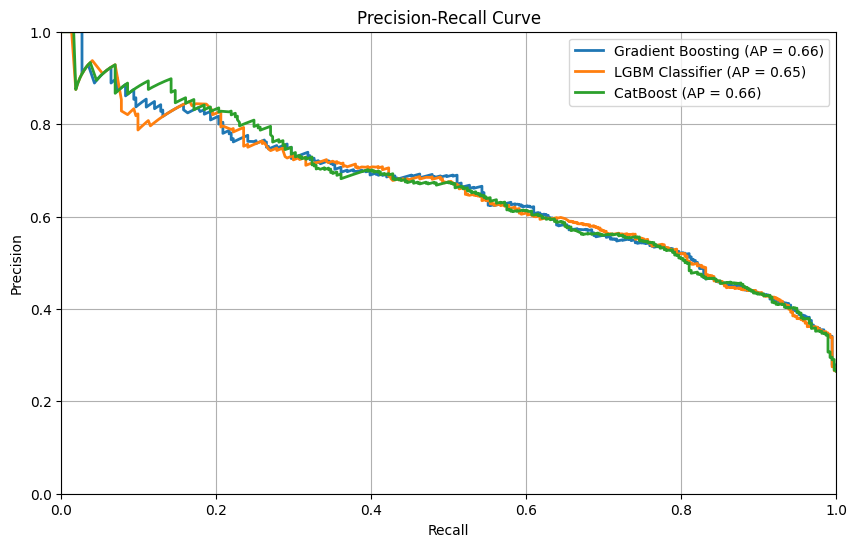

In [27]:
gb_tuned = best_models["Gradient Boosting"]
cb_tuned = best_models["CatBoost"]
lgbm_tuned = best_models["LightGBM"]

from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt
import numpy as np

y_scores = gb_tuned.predict_proba(X_test)[:, 1]

precision, recall, thresholds = precision_recall_curve(y_test, y_scores)
average_precision = average_precision_score(y_test, y_scores)

# Строим график
plt.figure(figsize=(10, 6))
plt.plot(recall, precision, linewidth=2, label=f'Gradient Boosting (AP = {average_precision:.2f})')

y_scores = lgbm_tuned.predict_proba(X_test)[:, 1]

precision, recall, thresholds = precision_recall_curve(y_test, y_scores)
average_precision = average_precision_score(y_test, y_scores)

plt.plot(recall, precision, linewidth=2, label=f'LGBM Classifier (AP = {average_precision:.2f})')

y_scores = cb_tuned.predict_proba(X_test)[:, 1]

precision, recall, thresholds = precision_recall_curve(y_test, y_scores)
average_precision = average_precision_score(y_test, y_scores)

plt.plot(recall, precision, linewidth=2, label=f'CatBoost (AP = {average_precision:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid(True)
plt.axis([0, 1, 0, 1])
plt.show()

In [28]:
def get_optimal_threshold(model, target='f1', target_score=0.8, help_metric='recall', help_metric_min_score=0.7):
    from sklearn.metrics import precision_recall_curve
    
    if (target not in ['f1', 'precision', 'recall']):
        raise ValueError("target must be 'f1', 'precision' or 'recall'.")
    
    if (help_metric not in ['precision', 'recall']):
        raise ValueError("target must be 'precision' or 'recall'.")
    
    def f1(precision_, recall_):
        if precision_ + recall_ == 0:
            return 0.0
        
        return 2 * (precision_ * recall_) / (precision_ + recall_)
    
    
    y_pred_proba = model.predict_proba(X_test)[:, 1]

    precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)

    f1s = []
    max_f1_score = 0
    max_f1_idx = 0

    for i in range(len(thresholds)):
        f1s.append(f1(precision[i], recall[i]))
        if max_f1_score < f1s[i]:
            if (help_metric is None):
                max_f1_score = f1s[i]
                max_f1_idx = i
            elif (help_metric == 'recall') and (recall[i] >= help_metric_min_score):
                max_f1_score = f1s[i]
                max_f1_idx = i
            elif (help_metric == 'precision') and (precision[i] >= help_metric_min_score):
                max_f1_score = f1s[i]
                max_f1_idx = i

    optimal_idx_recall = np.argmin(recall >= target_score)
    optimal_idx_precision = np.argmin(recall >= target_score)
    optimal_threshold_recall = thresholds[optimal_idx_recall]
    optimal_threshold_precision = thresholds[optimal_idx_precision]
    optimal_threshold_f1 = thresholds[max_f1_idx]

    if target == 'f1':
        return optimal_threshold_f1
    elif target == 'recall':
        return optimal_threshold_recall
    elif target == 'precision':
        return optimal_threshold_precision

In [29]:
from sklearn.model_selection import FixedThresholdClassifier

optimal_threshold_CB = get_optimal_threshold(model=cb_tuned, target='f1', help_metric='recall', help_metric_min_score=0.8)
optimal_threshold_GB = get_optimal_threshold(model=gb_tuned, target='f1', help_metric='recall', help_metric_min_score=0.8)
optimal_threshold_LGBM = get_optimal_threshold(model=lgbm_tuned, target='f1', help_metric='recall', help_metric_min_score=0.8)
 
cb_tuned = FixedThresholdClassifier(cb_tuned, threshold=optimal_threshold_CB)
cb_tuned.fit(X_train, y_train)
gb_tuned = FixedThresholdClassifier(gb_tuned, threshold=optimal_threshold_GB)
gb_tuned.fit(X_train, y_train)
lgbm_tuned = FixedThresholdClassifier(lgbm_tuned, threshold=optimal_threshold_LGBM)
lgbm_tuned.fit(X_train, y_train)


y_pred_otimised_CB = cb_tuned.predict(X_test)
y_pred_otimised_GB = gb_tuned.predict(X_test)
y_pred_otimised_LGBM = lgbm_tuned.predict(X_test)

In [30]:
print(f'CB THRESHOLD: {optimal_threshold_CB}')
print(f'F1: {f1_score(y_test, y_pred_otimised_CB)}')
print(f'P: {precision_score(y_test, y_pred_otimised_CB)}')
print(f'R: {recall_score(y_test, y_pred_otimised_CB)}')
print()
print(f'GB THRESHOLD: {optimal_threshold_GB}')
print(f'F1: {f1_score(y_test, y_pred_otimised_GB)}')
print(f'P: {precision_score(y_test, y_pred_otimised_GB)}')
print(f'R: {recall_score(y_test, y_pred_otimised_GB)}')
print()
print(f'LGBM THRESHOLD: {optimal_threshold_LGBM}')
print(f'F1: {f1_score(y_test, y_pred_otimised_LGBM)}')
print(f'P: {precision_score(y_test, y_pred_otimised_LGBM)}')
print(f'R: {recall_score(y_test, y_pred_otimised_LGBM)}')

# THRESHOLD: 0.4636498354792728
# F1: 0.6237006237006237
# P: 0.5102040816326531
# R: 0.8021390374331551

CB THRESHOLD: 0.46690582256808294
F1: 0.6230529595015576
P: 0.5093378607809848
R: 0.8021390374331551

GB THRESHOLD: 0.47477617073165734
F1: 0.6332288401253918
P: 0.5197255574614065
R: 0.8101604278074866

LGBM THRESHOLD: 0.48749516770272694
F1: 0.6316894018887723
P: 0.5198618307426598
R: 0.8048128342245989


# Ансамблирование лучших моделей

Возьму только две лучшие модели - Gradient Boosting, LGBM.

In [35]:
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import cross_val_predict

final_system = VotingClassifier(estimators=[('cb', cb_tuned), ('gb', gb_tuned), ('lgbm', lgbm_tuned)], voting='soft')

y_pred_gb = cross_val_predict(cb_tuned, X_train, y_train, cv=10, n_jobs=-1)
y_pred_final = cross_val_predict(final_system, X_train, y_train, cv=10, n_jobs=-1)

print(f'MODEL: GB')
print(f'F1: {f1_score(y_train, y_pred_gb)}')
print(f'P: {precision_score(y_train, y_pred_gb)}')
print(f'R: {recall_score(y_train, y_pred_gb)}')
print(f'AUC: {roc_auc_score(y_train, y_pred_gb)}')
print()
print(f'MODEL: ENSEMBLE')
print(f'F1: {f1_score(y_train, y_pred_final)}')
print(f'P: {precision_score(y_train, y_pred_final)}')
print(f'R: {recall_score(y_train, y_pred_final)}')
print(f'AUC: {roc_auc_score(y_train, y_pred_final)}')

MODEL: GB
F1: 0.6310856547774017
P: 0.5166240409207161
R: 0.8107023411371237
AUC: 0.768361559551408

MODEL: ENSEMBLE
F1: 0.6348104644954619
P: 0.528209684584629
R: 0.7953177257525084
AUC: 0.7693670049395545


Ансамбль очень незначительно улучшил ситуацию, оставим просто CatBoost!

# Визуализация ошибок модели (LR)

In [42]:
y_pred_test = cb_tuned.predict(X_test)

c:\Coding\customer-churn-prediction\.venv\Lib\site-packages\imblearn\pipeline.py:65: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 0.15 instead of the current warning.
  warnings.warn(


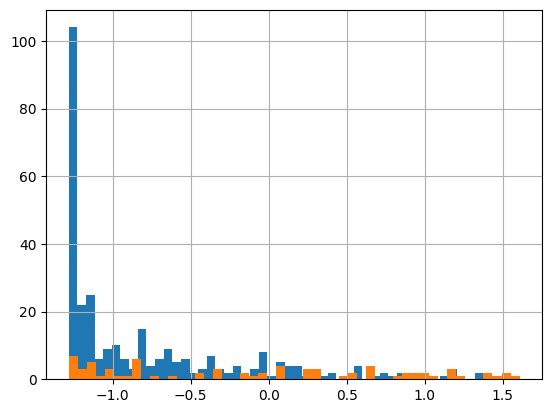

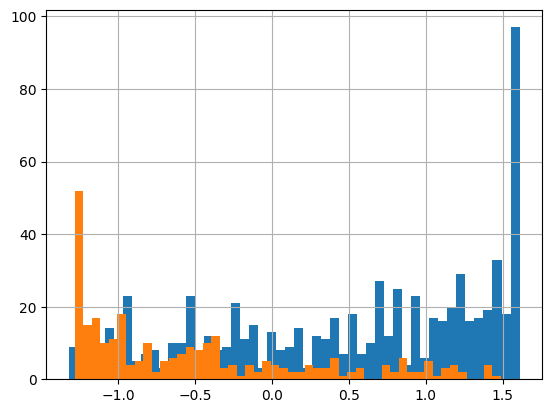

In [43]:
X_test_preprocessed = preprocessing[:-1].transform(X_test)

false_negative = X_test_preprocessed[
    (y_pred_test == 0) & (y_test == 1)
]
true_positive = X_test_preprocessed[
    (y_pred_test == 1) & (y_test == 1)
]
false_positive = X_test_preprocessed[
    (y_pred_test == 1) & (y_test == 0)
]
true_negative = X_test_preprocessed[
    (y_pred_test == 0) & (y_test == 0)
]

col = "num__tenure"
true_positive[col].hist(bins=50)
false_negative[col].hist(bins=50)
plt.show()

true_negative[col].hist(bins=50)
false_positive[col].hist(bins=50)
plt.show()

In [44]:
# Добавим метки для каждого типа предсказания
X_test_with_errors = preprocessing[:-1].transform(X_test)
X_test_with_errors['true_label'] = y_test
X_test_with_errors['predicted_label'] = y_pred_test
X_test_with_errors['error_type'] = 'correct'
X_test_with_errors.loc[(y_pred_test == 0) & (y_test == 1), 'error_type'] = 'false_negative'
X_test_with_errors.loc[(y_pred_test == 1) & (y_test == 0), 'error_type'] = 'false_positive'
X_test_with_errors.loc[(y_pred_test == 1) & (y_test == 1), 'error_type'] = 'true_positive'
X_test_with_errors.loc[(y_pred_test == 0) & (y_test == 0), 'error_type'] = 'true_negative'

# Сравним средние значения признаков по группам
error_summary = X_test_with_errors.groupby('error_type').mean().T
print(error_summary)

error_type                                     false_negative  false_positive  \
num__MonthlyCharges                                 -0.012833        0.276800   
num__tenure                                         -0.076404       -0.505961   
num__MonthlyCharges tenure                           0.082198       -0.242978   
log__TotalCharges                                   -0.007308       -0.250248   
yes_no__Partner                                      0.527027        0.352941   
yes_no__Dependents                                   0.405405        0.141869   
yes_no__OnlineSecurity                               0.472973        0.134948   
yes_no__TechSupport                                  0.472973        0.173010   
yes_no__StreamingTV                                  0.432432        0.394464   
yes_no__PaperlessBilling                             0.581081        0.719723   
1hot__InternetService_DSL                            0.472973        0.252595   
1hot__InternetService_Fiber 

c:\Coding\customer-churn-prediction\.venv\Lib\site-packages\imblearn\pipeline.py:65: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 0.15 instead of the current warning.
  warnings.warn(


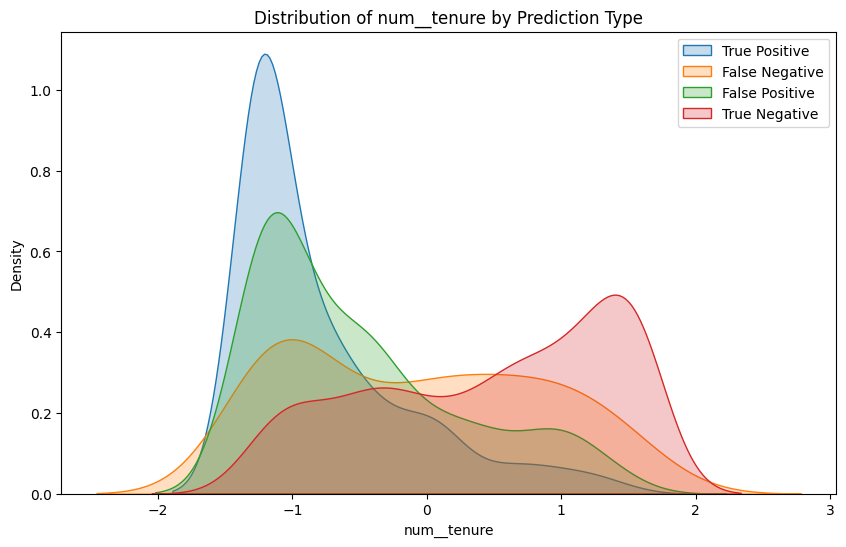

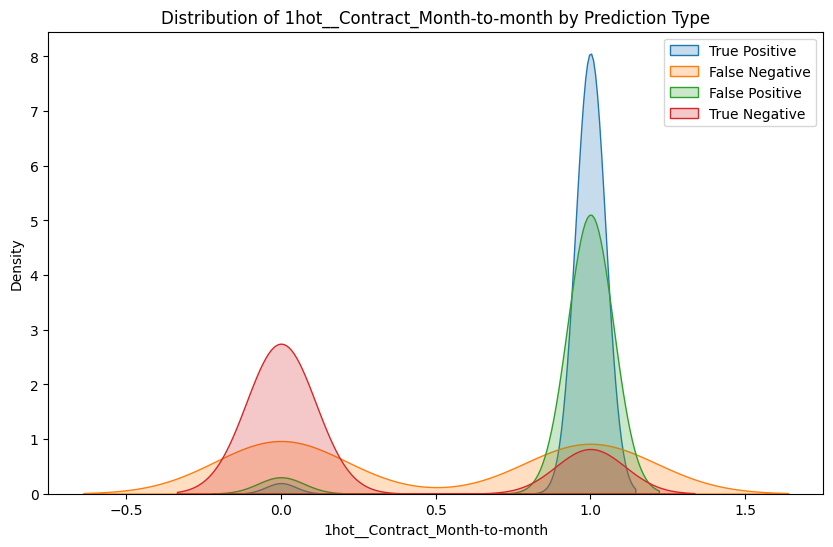

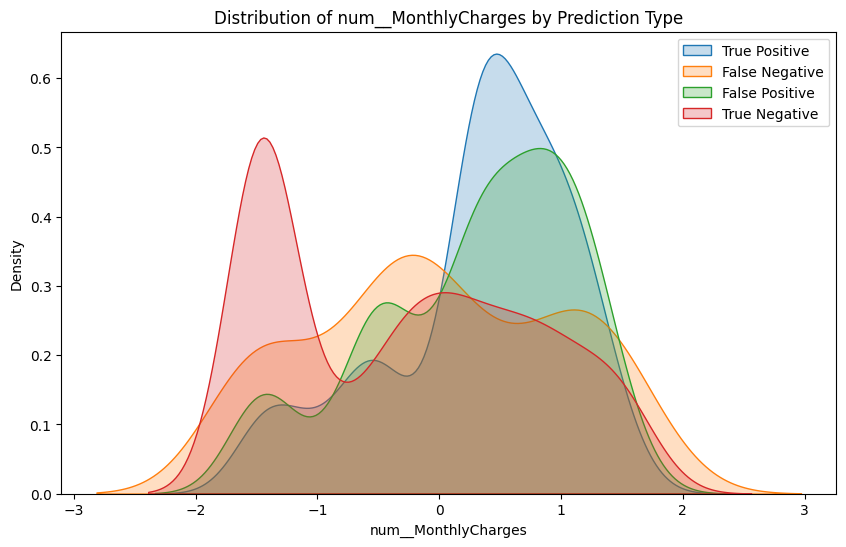

In [46]:
# Выберем несколько наиболее важных признаков
important_features = ['num__tenure', '1hot__Contract_Month-to-month', 'num__MonthlyCharges']
import seaborn as sns

for feature in important_features:
    plt.figure(figsize=(10, 6))
    
    # Сравним распределения для разных типов ошибок
    sns.kdeplot(data=true_positive[feature], label='True Positive', fill=True)
    sns.kdeplot(data=false_negative[feature], label='False Negative', fill=True)
    sns.kdeplot(data=false_positive[feature], label='False Positive', fill=True)
    sns.kdeplot(data=true_negative[feature], label='True Negative', fill=True)
    
    plt.title(f'Distribution of {feature} by Prediction Type')
    plt.legend()
    plt.show()

Скорее всего модель ошибается из-за линейной неразделимости классов.